# Running SUMMA using pySUMMA

[HydroShare Resource Link](https://www.hydroshare.org/resource/c75ad34da9d642aca6e51126bfff45d1/)

To begin, we have to regionalize the paths in the configuration files that SUMMA will use.
This is accomplished by running a shell command. This is done by starting a line with the `!` operator.
We simply run a script to complete the installation.
Then, we can import some basic libraries along with `pysumma`.
Note, if you run this with all 671 basins, you may be maxing out memory. 
If things start to fail, restart the server and run the simuluations in smaller loops before restarts. Also, make sure you start with 16GB per node on the Cheyenne PBS Job Options. 

<br>
Check that we loaded the correct environment.

In [1]:
conda list summa

# packages in environment at /opt/conda/envs/pysumma:
#
# Name                    Version                   Build  Channel
pysumma                   3.0.3                    pypi_0    pypi

Note: you may need to restart the kernel to use updated packages.


<br>
Load the imports.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pysumma as ps
import xarray as xr
import pandas as pd
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import gc
import os

<br>

### You will need to edit these paths to be your folders

<br>
Keep these the same.

In [3]:
top_folder = os.path.join(os.getcwd(), 'summa_camels')
settings_folder = os.path.join(top_folder, 'settings.v1')
ps_working = os.path.join(top_folder, '/.pysumma')

In [4]:
! cd {top_folder}; chmod +x install_local_setup.sh; ./install_local_setup.sh

<br>

### Make problem complexity choices here:

Now decide if you want to run: 
 - `default_prob = 1`: the "default" configuration with the "default" parameters. By "default" we mean whatever you chose in the summa setup files. 
 - `lhc_prob = 1`: the default configuration with exploration of the parameter space.
 - `lhc_config_prob = 1`: 8 different configurations (choices that have been seen to affect the model output in previous research) with exploration of the parameter space.
 
Note, you can choose all of these to be 1, but each step of complexity will contain the previous problem(s), so it is not necessary. It will result in more files, but if may be useful to check that each step of the problem expansion runs successfullly. If you have more than 10 HRUs (CAMELs subbasins in the example problem), it was decided that the problem is too big and you can only run the default problem. However, theoretically it will run with more HRUs. 

In [5]:
# get number of HRUs
attrib = xr.open_dataset(settings_folder+'/attributes.nc')
the_hru = np.array(attrib['hruId'])

In [6]:
default_prob = 1
lhc_prob = 1
lhc_config_prob = 1
if len(the_hru) >10:
    lhc_prob = 0
    lhc_config_prob = 0

## Interacting with SUMMA via the `Distributed` object

We are running a `Distributed` object, which has multiple `Simulation` objects inside, each corresponding to some spatial chunk. 
We need to do `rm -r /glade/work/ashleyvb/CAMELs/summa_camels/.pysumma/` to clear out the distributed folders every run so permissions do not get screwed up in the loops. 

In [7]:
from distributed import Client, get_client

client = Client()
client
#client = get_client()
#client
# for fewer basins, do not exceed number of basins in chunking
CHUNK = 8 #for all 671 basins
if len(the_hru) <8: CHUNK = len(the_hru) + 1
NCORES=2   

<br>

To set up a `Distributed` object you must supply several pieces of information. 
First, supply the SUMMA executable; this could be either the compiled executable on your local machine, or a docker image. 
The second piece of information is the path to the file manager, which we just created through the install script. 

In [8]:
executable = '/usr/bin/summa.exe'
file_manager = top_folder+'/file_manager_truth.txt'
camels = ps.Distributed(executable, file_manager, num_workers=NCORES, chunk_size=CHUNK, client=client)
camels.manager['simStartTime'] = '1980-10-01 00:00'
camels.manager['simEndTime'] = '1982-09-30 23:00'
camels.manager.write()
print(camels.manager) #possible days 1980-01-01 to 2018-12-31, we are running 1986-10-01 01:00 to 1991-10-02 0:00

controlVersion                       'SUMMA_FILE_MANAGER_V3.0.0'
simStartTime                         '1980-10-01 00:00'
simEndTime                           '1982-09-30 23:00'
tmZoneInfo                           'utcTime'
settingsPath                         '/home/jovyan/work/Downloads/c75ad34da9d642aca6e51126bfff45d1/c75ad34da9d642aca6e51126bfff45d1/data/contents/summa_camels/settings.v1/'
forcingPath                          '/home/jovyan/work/Downloads/c75ad34da9d642aca6e51126bfff45d1/c75ad34da9d642aca6e51126bfff45d1/data/contents/summa_camels/forcing/truth/'
outputPath                           '/home/jovyan/work/Downloads/c75ad34da9d642aca6e51126bfff45d1/c75ad34da9d642aca6e51126bfff45d1/data/contents/summa_camels/output/truth/'
decisionsFile                        'modelDecisions.1hr.txt'
outputControlFile                    'output_control2.txt'
globalHruParamFile                   '../settings.v1/localParamInfo.txt'
globalGruParamFile                   '../settings.v1/basinPa

## pySUMMA with all Forcing Files

We run pySumma for each set of forcing files on each basin. You can check how long it has been running by using the command `qstat -u <username>` in a terminal. Each run takes about 9 minutes for 671 basins (shorter if a subset). First, we start with the original NLDAS files, or the "truth run".

In [9]:
%%time
# truth, default parameters and configuration
if default_prob==1:
    camels.run('local')
    all_status = [(n, s.status) for n, s in camels.simulations.items()] #if want to look at status if has errors
    all_ds = [s.output.load() for n, s in camels.simulations.items()] #load it into memory so faster

CPU times: user 956 ms, sys: 71.2 ms, total: 1.03 s
Wall time: 19.9 s


<br>
We could just write it as several files instead of merging. However, if we want to merge, we can do the following.
First, detect automatically which vars have hru vs gru dimensions (depending on what we use for output, we may not have any gru):

In [10]:
if default_prob==1:
    hru_vars = [] # variables that have hru dimension
    gru_vars = [] # variables that have gru dimension
    for ds in all_ds:
        for name, var in ds.variables.items():
            if 'hru' in var.dims:
                hru_vars.append(name)
            elif 'gru' in var.dims:
                gru_vars.append(name)

<br>
Filter variables for merge, this takes seconds since we are running a limiited output, but if you add more to the output it will take longer.

In [11]:
%%time
if default_prob==1:
    hru_ds = [ds[hru_vars] for ds in all_ds]
    gru_ds = [ds[gru_vars] for ds in all_ds]
    hru_merged = xr.concat(hru_ds, dim='hru')
    gru_merged = xr.concat(gru_ds, dim='gru')
    print(hru_merged)

<xarray.Dataset>
Dimensions:                (hru: 1, time: 17520)
Coordinates:
  * hru                    (hru) int64 1413500
  * time                   (time) datetime64[ns] 1980-10-01 ... 1982-09-30T23...
Data variables:
    pptrate                (time, hru) float64 0.0 0.0 0.0 ... 2.307e-07 0.0 0.0
    airtemp                (time, hru) float64 286.4 286.0 285.6 ... 289.3 288.2
    spechum                (time, hru) float64 0.007473 0.007536 ... 0.009017
    windspd                (time, hru) float64 3.881 3.879 3.899 ... 2.334 2.467
    SWRadAtm               (time, hru) float64 0.0 0.0 0.0 ... 218.5 89.01 0.0
    LWRadAtm               (time, hru) float64 299.0 299.0 299.0 ... 356.1 356.1
    airpres                (time, hru) float64 9.399e+04 9.399e+04 ... 9.461e+04
    scalarCanopyWat        (time, hru) float64 0.0 2.619e-17 ... 0.007718
    scalarSWE              (time, hru) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    scalarTotalSoilWat     (time, hru) float64 1.597e+03 1.596

In [12]:
%%time
if default_prob==1:
    hru_merged.to_netcdf(top_folder+'/output/merged_day/NLDAStruth_hru.nc')
    gru_merged.to_netcdf(top_folder+'/output/merged_day/NLDAStruth_gru.nc')
    del camels
    del all_ds 
    del hru_merged
    del gru_merged
    gc.collect()

CPU times: user 237 ms, sys: 39 ms, total: 276 ms
Wall time: 287 ms


In [13]:
%%time
# Each forcing constant, default parameters and configuration
if default_prob==1:
    constant_vars= ['airpres','airtemp','LWRadAtm','pptrate','spechum','SWRadAtm','windspd']
    for v in constant_vars:
        ! rm -rf {ps_working}
        file_manager = top_folder+'/file_manager_constant_' + v +'.txt'
        camels = ps.Distributed(executable, file_manager, num_workers=NCORES, chunk_size=CHUNK, client=client)  
        camels.manager['simStartTime'] = '1980-10-01 00:00'
        camels.manager['simEndTime'] = '1982-09-30 23:00'
        camels.manager.write()
        camels.run('local')
        all_status = [(n, s.status) for n, s in camels.simulations.items()] #if want to look at status if has errors
        all_ds = [s.output.load() for n, s in camels.simulations.items()] #load it into memory so faster    
        hru_vars = [] # variables that have hru dimension
        gru_vars = [] # variables that have gru dimension
        for ds in all_ds:
            for name, var in ds.variables.items():
                if 'hru' in var.dims:
                    hru_vars.append(name)
                elif 'gru' in var.dims:
                    gru_vars.append(name)
        hru_ds = [ds[hru_vars] for ds in all_ds]
        gru_ds = [ds[gru_vars] for ds in all_ds]
        hru_merged = xr.concat(hru_ds, dim='hru')
        gru_merged = xr.concat(gru_ds, dim='gru')
        hru_merged.to_netcdf(top_folder+'/output/merged_day/NLDASconstant_' + v +'_hru.nc')
        gru_merged.to_netcdf(top_folder+'/output/merged_day/NLDASconstant_' + v +'_gru.nc')
        del camels
        del all_ds 
        del hru_merged
        del gru_merged
        gc.collect()
        print(v)

airpres
airtemp
LWRadAtm
pptrate
spechum
SWRadAtm
windspd
CPU times: user 7.6 s, sys: 1.04 s, total: 8.64 s
Wall time: 2min 17s


## Exploring the Parameter Calibration Space with a Latin Hyper cube

The above models were run on the default parameter set only. Let's rerun with parameter sets selected by using a Latin Hyper cube to get 10 different parameter sets for every HRU, in order to explore the calibration space. This will show us if the results of forcing importance could change after calibration. 

Currrently, none of the model parameters (or decisions) can be altered in a `Distributed` object. 
However, if we switch to `Simulation` objects and use the `Ensemble` class, we can run suites of different model parameters with relative ease. 

We change only the parameters that are usually calibrated. You can remove parameters if you were not planning to ever calibrate them away from their defaults (likewise you could add parameters).

The absolute minimums and maximums will break simulations and zero out variables, so we do not use those, we stay at the 5% level away from the extremes. Also, there are some constraints on the parameters that must be followed, they are:

* heightCanopyTop   > heightCanopyBottom
* critSoilTranspire > theta_res
* theta_sat         > critSoilTranspire
* fieldCapacity     > theta_res
* theta_sat         > fieldCapacity
* theta_sat         > theta_res
* critSoilTranspire > critSoilWilting
* critSoilWilting   > theta_res

Since we must have a small subset of basins, we will proceed with the ensemble calculations with the parameter space
Afterwards, you can run the notebook `camels_analyze_subset_output.ipynb`.

In [14]:
if lhc_prob==1 or lhc_config_prob==1: from pyDOE import lhs

In [15]:
if lhc_prob==1 or lhc_config_prob==1:
    file_manager = top_folder+'/file_manager_truth.txt'
    s = ps.Simulation(executable, file_manager)

In [16]:
# print the default, min, and max as in /settings.v1/localParamInfo.txt and /settings.v1/basinParamInfo.txt
if lhc_prob==1 or lhc_config_prob==1:
    param_calib_hru = ['albedoRefresh', 'aquiferBaseflowExp', 'aquiferBaseflowRate', 'frozenPrecipMultip', 'heightCanopyBottom','heightCanopyTop', 'k_macropore', 
                   'k_soil', 'qSurfScale', 'summerLAI', 'tempCritRain', 'theta_sat', 'windReductionParam'] 
    param_calib_gru = ['routingGammaScale', 'routingGammaShape']

    for k in param_calib_hru:
        print(s.global_hru_params[k])
    for k in param_calib_gru:
        print(s.global_gru_params[k]) 

albedoRefresh             |       1.0000 |       1.0000 |      10.0000
aquiferBaseflowExp        |       2.0000 |       1.0000 |      10.0000
aquiferBaseflowRate       |       0.1000 |       0.0000 |       0.1000
frozenPrecipMultip        |       1.0000 |       0.5000 |       1.5000
heightCanopyBottom        |       2.0000 |       0.0000 |       5.0000
heightCanopyTop           |      20.0000 |       0.0500 |     100.0000
k_macropore               |       0.0010 |       1.0d-7 |       0.1000
k_soil                    |       7.5d-6 |       1.0d-7 |       1.0d-5
qSurfScale                |      50.0000 |       1.0000 |     100.0000
summerLAI                 |       3.0000 |       0.0100 |      10.0000
tempCritRain              |     273.1600 |     272.1600 |     274.1600
theta_sat                 |       0.5500 |       0.3000 |       0.6000
windReductionParam        |       0.2800 |       0.0000 |       1.0000
routingGammaScale         |       2.0d+4 |       1.0000 |       1.0d+5
routin

In [17]:
if lhc_prob==1 or lhc_config_prob==1:
    bounds_hru = np.full((len(param_calib_hru),3),1.0)
    bounds_gru = np.full((len(param_calib_gru),3),1.0)
    for i,k in enumerate(param_calib_hru): bounds_hru[i,]= s.global_hru_params.get_value(k)[0:3]
    for i,k in enumerate(param_calib_gru): bounds_gru[i,]= s.global_gru_params.get_value(k)[0:3]

In [18]:
# Define bounds and expand to size of LHS runs
if lhc_prob==1 or lhc_config_prob==1:
    numl = 1
    num_vars =  len(param_calib_hru) + len(param_calib_gru)
    names =  param_calib_hru + param_calib_gru
    bounds =  np.concatenate((bounds_hru, bounds_gru), axis=0)
    par_def = dict(zip(names, np.transpose(np.tile(bounds[:,0],(len(the_hru),1))) ))
    par_min = dict(zip(names, np.transpose(np.tile(bounds[:,1],(numl*len(the_hru),1))) ))
    par_max = dict(zip(names, np.transpose(np.tile(bounds[:,2],(numl*len(the_hru),1))) ))

In [19]:
# Make sure to obey parameter constraints
if lhc_prob==1 or lhc_config_prob==1:
    param = xr.open_dataset(settings_folder+'/parameters.nc')

    for i,h in enumerate(the_hru):
        lb_theta_sat = max(param[['critSoilTranspire','fieldCapacity','theta_res']].isel(hru=i).values()).values
        for j in range(0,numl): #say first numl belong to hru 0, second numl to hru 1, and so on
            if (par_min['theta_sat'][j + i*numl]<lb_theta_sat): par_min['theta_sat'][j + i*numl]=lb_theta_sat

    par_min['heightCanopyTop'] = par_max['heightCanopyBottom']

In [20]:
# Add a 5% buffer
if lhc_prob==1 or lhc_config_prob==1:
    buff = {key: (par_max.get(key) - par_min.get(key))*0.25 for key in set(par_max) }
    par_min = {key: par_min.get(key) + buff.get(key)*0.25 for key in set(buff) }
    par_max = {key: par_max.get(key) - buff.get(key)*0.25 for key in set(buff) }

In [21]:
# Generate samples with Latin Hypercube Sampling
if lhc_prob==1 or lhc_config_prob==1:
    np.random.seed(1111)
    lhd = lhs(numl*len(the_hru), samples=num_vars)
    lhd = dict(zip(names,lhd))
    samples = {key: par_min.get(key) + lhd.get(key)*(par_max.get(key) - par_min.get(key)) for key in set(par_max) }

<br>
Set 0 will be the default parameter set. This means the the default parameter set will be run again. We do this so that each finished SUMMA *.nc output file is complete.

In [22]:
# make ensembles
if lhc_prob==1 or lhc_config_prob==1:
    latin = {}
    latin[str(0)] = {'trial_parameters': {key: par_def.get(key) for key in set(par_def) }}
    for j in range(0,numl):
            latin[str(j+1)] = {'trial_parameters': {key: samples.get(key)[np.arange(j, len(the_hru)*numl, numl)] for key in set(samples) }}

<br>

Now we just do what we did before in the simulations previously, except here we merge with a new dimension of the the configuration decision identifier instead of by `hru` and `gru`. 

In [23]:
%%time
# truth, parameter space with default configuration
if lhc_prob==1:
    param_ens = ps.Ensemble(executable, latin, file_manager, num_workers=NCORES, client=client)   
    param_ens.run('local')
    all_status = [(n, s.status) for n, s in param_ens.simulations.items()] #if want to look at status if has errors
    all_ds = [s.output.load() for n, s in param_ens.simulations.items()] #load it into memory so faster  
    all_name = [n for n, s in param_ens.simulations.items()]
    all_merged = xr.concat(all_ds, pd.Index(all_name, name="decision"))
    all_merged.to_netcdf(top_folder+'/output/merged_day/NLDAStruth_latin.nc')
    del param_ens
    del all_ds 
    del all_merged

CPU times: user 5.59 s, sys: 910 ms, total: 6.5 s
Wall time: 34 s


In [24]:
# check that all were a success
if lhc_prob==1:
    print(all_status)

[('0', 'Success'), ('1', 'Success')]


In [25]:
%%time
# Each forcing constant, parameter space with default configuration
if lhc_prob==1:
    constant_vars= ['airpres','airtemp','LWRadAtm','pptrate','spechum','SWRadAtm','windspd']
    for v in constant_vars:
        ! rm -rf {ps_working}
        file_manager = top_folder+'/file_manager_constant_' + v +'.txt'
        s = ps.Simulation(executable, file_manager)
        s.manager['simStartTime'] = '1980-10-01 00:00'
        s.manager['simEndTime'] = '1982-09-30 23:00'
        s.manager.write()
        param_ens = ps.Ensemble(executable, latin, file_manager, num_workers=NCORES, client=client)   
        param_ens.run('local')
        all_status = [(n, s.status) for n, s in param_ens.simulations.items()] #if want to look at status if has errors
        all_ds = [s.output.load() for n, s in param_ens.simulations.items()] #load it into memory so faster  
        all_name = [n for n, s in param_ens.simulations.items()]
        all_merged = xr.concat(all_ds, pd.Index(all_name, name="decision"))
        all_merged.to_netcdf(top_folder+'/output/merged_day/NLDASconstant_' + v +'_latin.nc')
        del param_ens
        del all_ds 
        del all_merged
        gc.collect()
        print(v)

airpres
airtemp
LWRadAtm
pptrate
spechum
SWRadAtm
windspd
CPU times: user 39.9 s, sys: 5.13 s, total: 45.1 s
Wall time: 3min 49s


## Manipulating the Configuration of the pySUMMA Objects

We need to run the parameter space with other model configurations, to see if the results seen on the default configuration hold true across the parameter space. The new configurations follow the exploration of [this paper.](https://doi.org/10.1002/2015WR017200)

Clark, M.P., Nijssen, B., Lundquist, J.D., Kavetski, D., Rupp, D.E., Woods, R.A., Freer, J.E., Gutmann, E.D., Wood, A.W., Gochis, D.J. and Rasmussen, R.M., 2015. A unified approach for process‐based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51(4), pp.2515-2542.

Of the model configurations discussed in this paper, the decisions that made the most difference are:

 - `groundwatr` choice of groundwater parameterization as:
   - `qTopmodl` the topmodel parameterization (note must set hc_profile = pow_prof and bcLowrSoiH = zeroFlux
   - `bigBuckt` a big bucket (lumped aquifer model) in between the other two choices for complexity
   - `noXplict` no explicit groundwater parameterization
 - `stomResist` choice of function for stomatal resistance as:
   - `BallBerry` Ball-Berry (1987) parameterization of physiological factors controlling transpiration
   - `Jarvis` Jarvis (1976) parameterization of physiological factors controlling transpiration
   - `simpleResistance` parameterized solely as a function of soil moisture limitations
 - `snowIncept` choice of parameterization for snow interception as:
   - `stickySnow` maximum interception capacity is an increasing function of temerature
   - `lightSnow` maximum interception capacity is an inverse function of new snow density
 - `windPrfile` choice of wind profile as:
   - `exponential` an exponential wind profile extends to the surface
   - `logBelowCanopy` a logarithmic profile below the vegetation canopy

Choices `bigBuckt`, `BallBerry`, `lightSnow`, and `logBelowCanopy` are the defaults that we have run already (see the decisions printed out in the previous cell). The paper showed choice of `groundwatr` affecting the timing of runoff and the magnitude of evapotranspiration, `stomResist` affecting timing and magnitude of evapotranspiration, `snowIncept` affecting the magnitude canopy interception of snow, and `windPrfile` affecting the timing and magnitude of SWE, and latent and sensible heat. We will not explore the `groundwatr` configurations here as the differences show up only in most simulated variables post-calibration. This study does not examine models calibrated for every set up of forcings configurations. Note, if you want to look at `qTopmodl`, you must set  `bcLowrSoiH` to `zeroFlux` (we will leave it at `drainage`) and `hc_profile` to `pow_prof` (we will leave it at `constant`).

In [35]:
if lhc_config_prob==1:
    file_manager = top_folder+'/file_manager_truth.txt'
    s = ps.Simulation(executable, file_manager)
    #Before running the ensemble we must write the original simulation's configuration.
    s._write_configuration()
    print(s.decisions)

soilCatTbl    STAS                 ! soil-category dataset
vegeParTbl    MODIFIED_IGBP_MODIS_NOAH ! vegetation-category dataset
soilStress    NoahType             ! choice of function for the soil moisture control on stomatal resistance
stomResist    BallBerry            ! choice of function for stomatal resistance
num_method    itertive             ! choice of numerical method
fDerivMeth    analytic             ! choice of method to calculate flux derivatives
LAI_method    specified            ! choice of method to determine LAI and SAI
f_Richards    mixdform             ! form of Richards equation
groundwatr    bigBuckt             ! choice of groundwater parameterization
hc_profile    constant             ! choice of hydraulic conductivity profile
bcUpprTdyn    nrg_flux             ! type of upper boundary condition for thermodynamics
bcLowrTdyn    zeroFlux             ! type of lower boundary condition for thermodynamics
bcUpprSoiH    liq_flux             ! type of upper boundary c

In [36]:
if lhc_config_prob==1:
    #alld = {'groundwatr':np.array(['qTopmodl','bigBuckt']),
    alld = {'stomResist':np.array(['BallBerry','Jarvis'])}
    config = ps.ensemble.decision_product(alld)

<br>
The ensemble uses `++` as a delimiter to create unique identifiers for each simulation in the ensemble. The default configuration will be run again. We do this so that each finished SUMMA *.nc output file is complete.

In [37]:
# make ensembles with parameter space (numl parameter sets plus 1 for default)
if lhc_config_prob==1:
    config_latin = {}
    for key_config in config.keys():
        c = config[key_config]
        for key_latin in latin.keys():
            l = latin[key_latin]
            config_latin[key_config+key_latin] = {**c,**l}

<br>
Now, run these on the other forcing setups and parameter sets. Each iteration takes around 25 minutes with 4 basins.

In [29]:
%%time
# truth, parameter space with 8 configurations
if lhc_config_prob==1:
    param_ens = ps.Ensemble(executable, config_latin, file_manager, num_workers=NCORES, client=client)   
    param_ens.run('local')
    all_status = [(n, s.status) for n, s in param_ens.simulations.items()] #if want to look at status if has errors
    all_ds = [s.output.load() for n, s in param_ens.simulations.items()] #load it into memory so faster  
    all_name = [n for n, s in param_ens.simulations.items()]
    all_merged = xr.concat(all_ds, pd.Index(all_name, name="decision"))
    all_merged.to_netcdf(top_folder+'/output/merged_day/NLDAStruth_configs_latin.nc')

CPU times: user 6.9 s, sys: 838 ms, total: 7.74 s
Wall time: 1min 1s


In [31]:
# check that all were a success
if lhc_config_prob==1:
    print(all_status)

[('++BallBerry++0', 'Success'), ('++BallBerry++1', 'Success'), ('++Jarvis++0', 'Success'), ('++Jarvis++1', 'Success')]


<br>
To make sure things look how we want, we plot cumulative variables to see how differences are compounding.
We plot one HRU (the first one) for 2 months. We are showing winter months, but this can be switched to summer months.

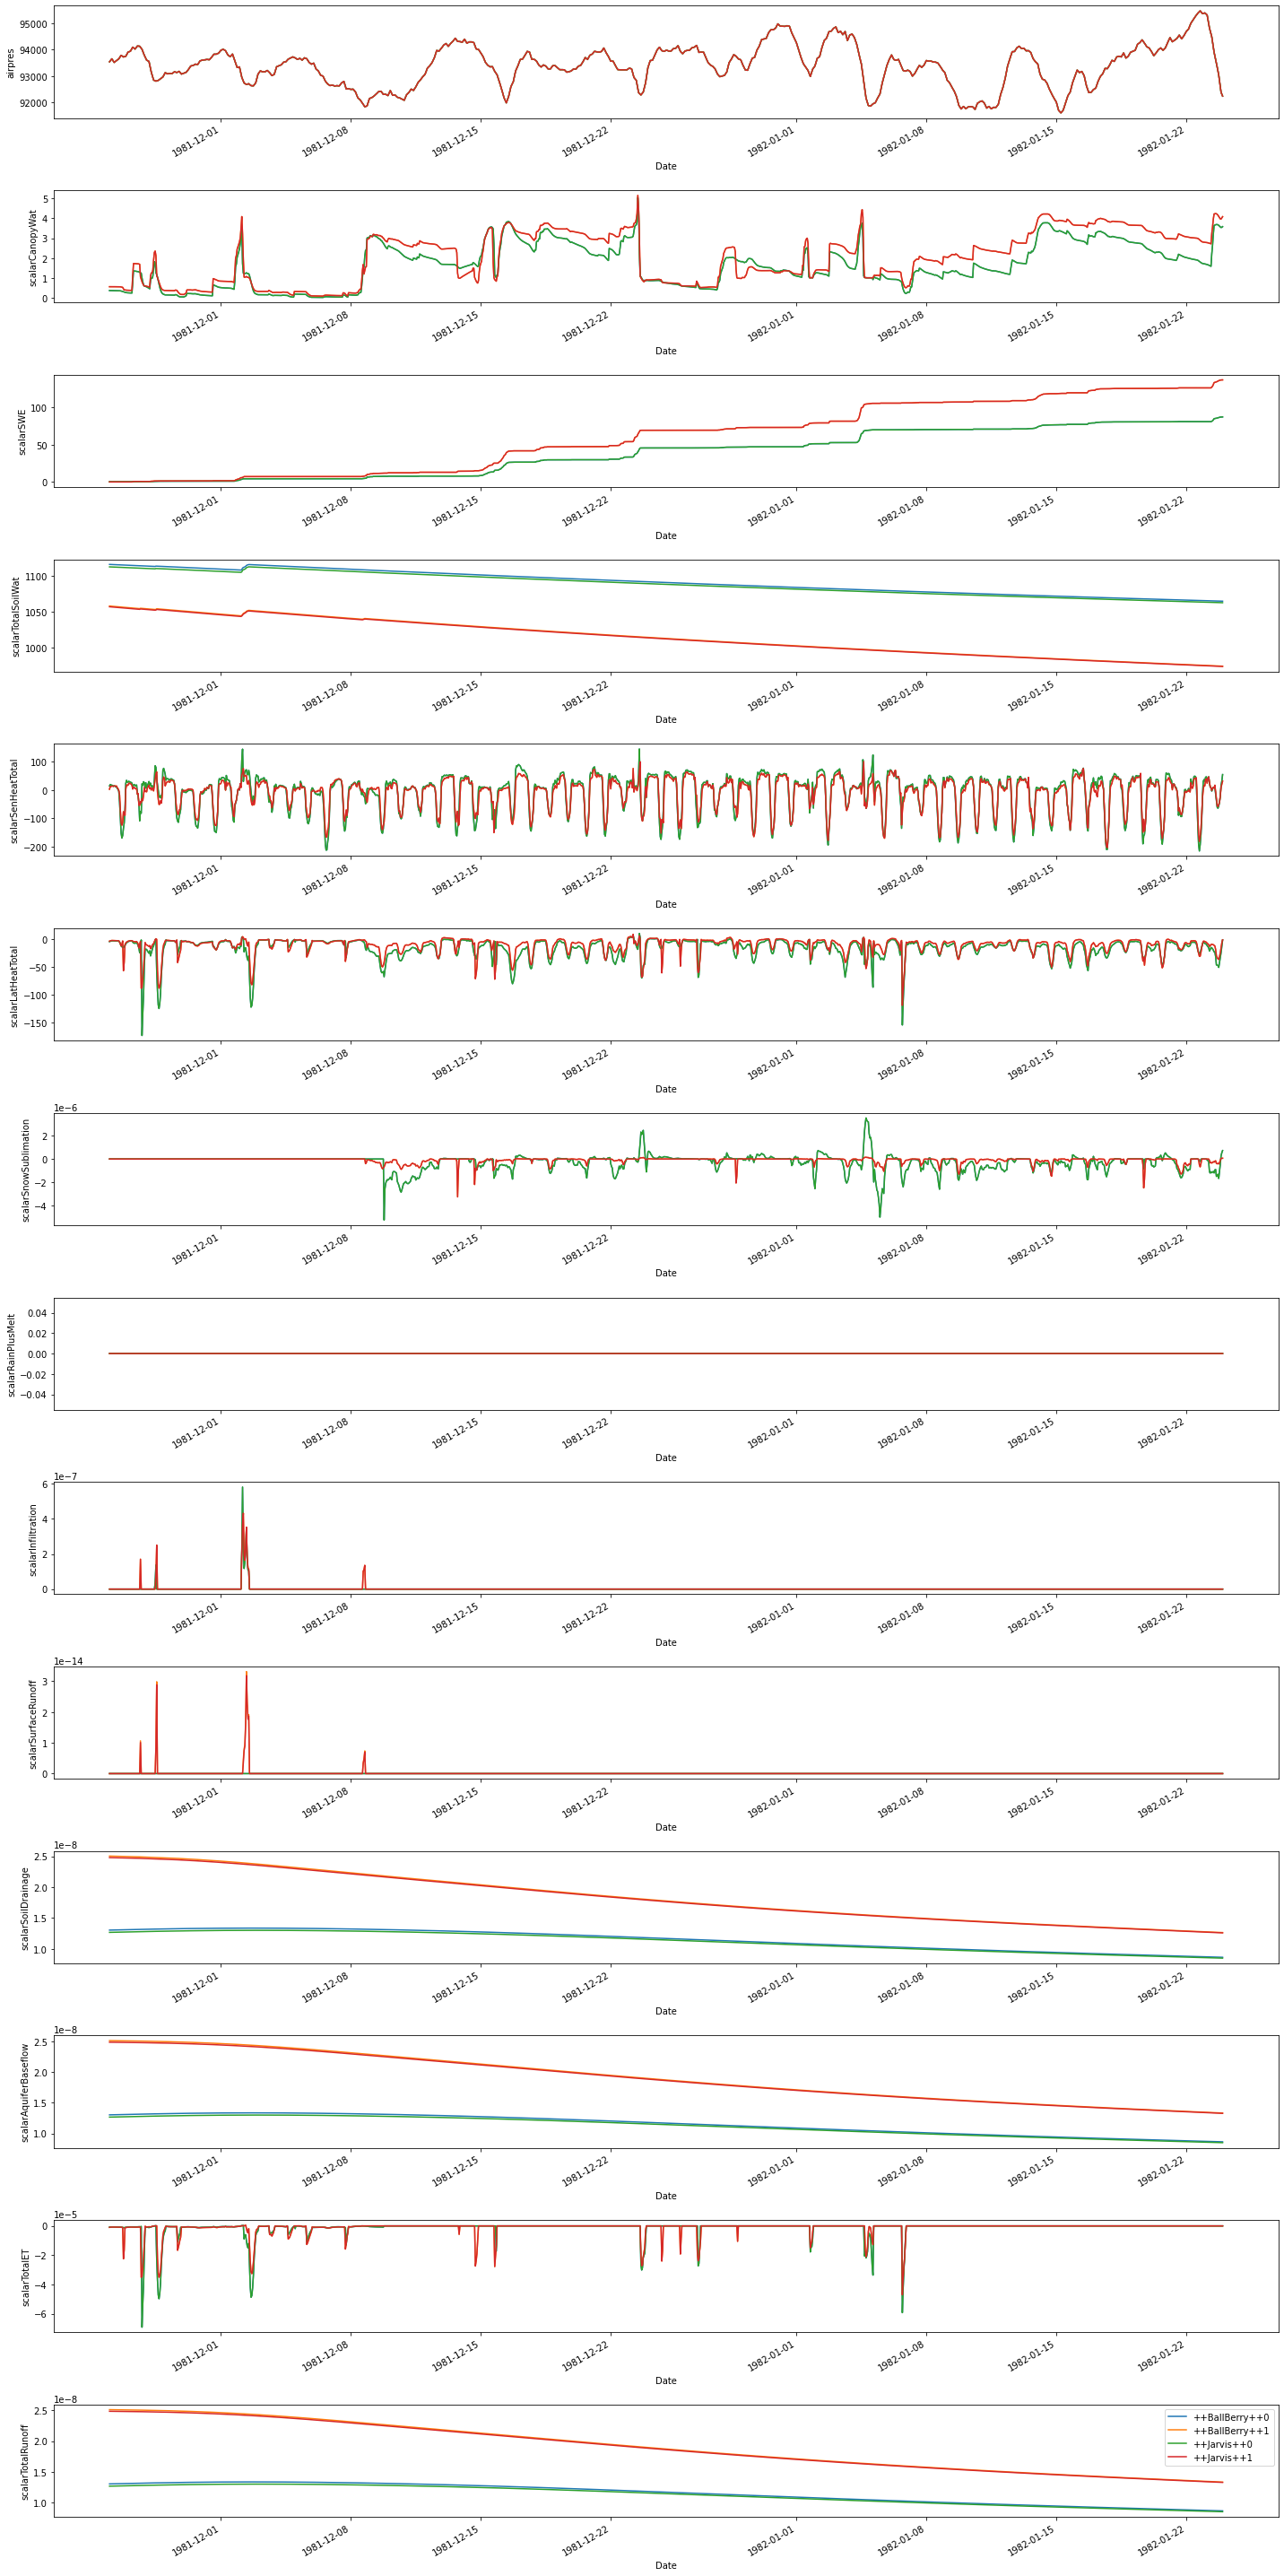

In [32]:
# Plot cummulative
if lhc_config_prob==1:
    fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(20, 40))
    axes = axes.flatten()
    axes[0].set_title('Cumulative')

    variables = list(all_merged.variables.keys())[7:22]

    #start =  24*5*30 #summer
    start =  24*11*30 #winter
    stop = start + 2*30*24 

    truth_plt = all_merged.isel(hru=0, time=slice(start+90*24, stop+90*24)) #.cumsum(dim='time')
    #truth_plt = all_merged.isel(hru=0).cumsum(dim='time')

    for idx, var in enumerate(variables[0:14]):
        for i, dec in enumerate(all_name):    
            truth_plt[var].isel(decision=i).plot(ax=axes[idx],label=dec)
        axes[idx].set_title('') 
        axes[idx].set_ylabel(var)
        axes[idx].set_xlabel('Date')
    plt.tight_layout()
    plt.legend()

In [33]:
#delete things to save memory as before
if lhc_config_prob==1:
    del param_ens
    del all_ds 
    del all_merged

<br>

You might have to restart the following loop with several smaller subsets of `constant_vars`. 
It takes a long time to run so the Client times out.

In [34]:
%%time
# Each forcing constant, parameter space with 8 configurations.
if lhc_config_prob==1:
    constant_vars= ['airpres','airtemp','LWRadAtm','pptrate','spechum','SWRadAtm','windspd']
    for v in constant_vars:
        ! rm -rf {ps_working}
        file_manager = top_folder+'/file_manager_constant_' + v +'.txt'
        s = ps.Simulation(executable, file_manager)
        s.manager['simStartTime'] = '1980-10-01 00:00'
        s.manager['simEndTime'] = '1982-09-30 23:00'
        s.manager.write()
        param_ens = ps.Ensemble(executable, config_latin, file_manager, num_workers=NCORES, client=client)   
        param_ens.run('local')
        all_status = [(n, s.status) for n, s in param_ens.simulations.items()] #if want to look at status if has errors
        all_ds = [s.output.load() for n, s in param_ens.simulations.items()] #load it into memory so faster  
        all_name = [n for n, s in param_ens.simulations.items()]
        all_merged = xr.concat(all_ds, pd.Index(all_name, name="decision"))
        all_merged.to_netcdf(top_folder+'/output/merged_day/NLDASconstant_' + v +'_configs_latin.nc')
        del param_ens
        del all_ds 
        del all_merged
        gc.collect()
        print(v)

airpres
airtemp
LWRadAtm
pptrate
spechum
SWRadAtm
windspd
CPU times: user 49.5 s, sys: 6.22 s, total: 55.7 s
Wall time: 7min 1s
